# Survival Analysis with Neural Networks
This notebook demonstrates a complete workflow for survival analysis using a custom multi-task neural network model. The notebook covers data preparation, model definition, training, and evaluation.

# Data Preparation

## installing the necessary libraries.

In [ ]:
!pip install scikit-learn==1.0.2
!pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 64.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.15.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 89.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sksurv.metrics import concordance_index_censored
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam


## Loading the dataset from an Excel file and performing necessary preprocessing

In [ ]:

data = pd.read_excel('4A_TB_cleaned.xlsx')

# function to calculate the survival status
def calculate_survival_status(row):
    if row['OUT COME'] == 'DIED':
        return 1
    else:
        return 0


data['SURVIVAL'] = data.apply(calculate_survival_status, axis=1)

data.drop(columns=['UNIT','DISTRICT OF RESIDENCE','WORKING DIAGNOSIS','ADDITIONAL WORKING DIAGNOSIS',
                   'MARITAL STATUS', 'IP NUMBER', 'OUT COME'], inplace=True)

new_col_order = ['SEX', 'AGE', 'RELIGION', 'REGION', 'NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'TB_type',
                 'NUMBER OF PREVIOUS ADMISSIONS', 'DAY OF ADMISSION', 'MONTH OF ADMISSION',
                 'YEAR OF ADMISSION', 'DURATION', 'SURVIVAL']
data = data[new_col_order]

data.dropna(subset=['SURVIVAL'], inplace=True)
data.reset_index(drop=True, inplace=True)
data['SURVIVAL'] = data['SURVIVAL'].astype(int)

data.shape

(16368, 12)

In [ ]:
data.head()

,SEX,AGE,RELIGION,REGION,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,TB_type,NUMBER OF PREVIOUS ADMISSIONS,DAY OF ADMISSION,MONTH OF ADMISSION,YEAR OF ADMISSION,DURATION,SURVIVAL
0,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
1,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
2,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
3,M,30,COU,CENTRAL,1,Abdominal_TB,5,Tuesday,November,2010,6,0
4,F,46,COU,CENTRAL,1,Disseminated TB,3,Monday,December,2010,4,0


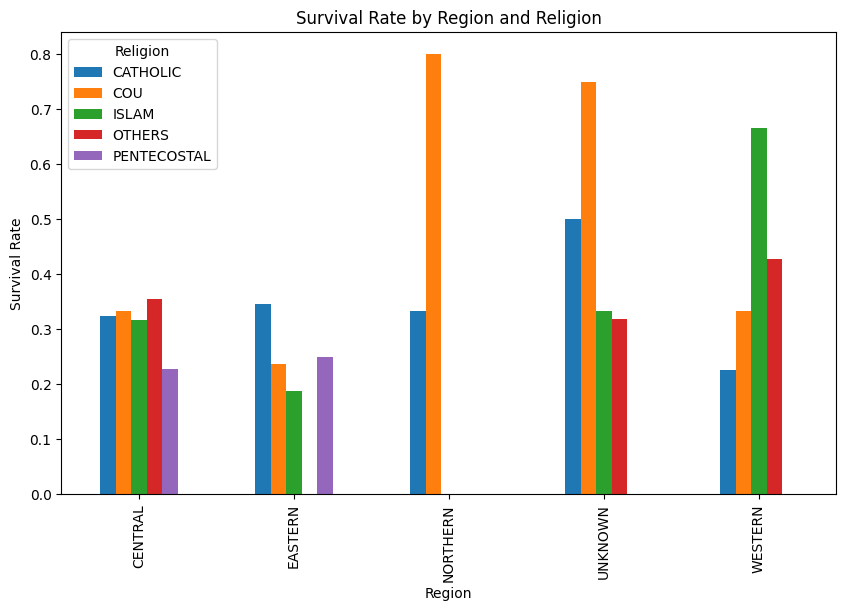

In [ ]:
# @title Survival Rate by Region and Religion

import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' is a pandas DataFrame
survival_rates = data.groupby(['REGION', 'RELIGION'])['SURVIVAL'].mean().unstack()
survival_rates.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Region')
plt.ylabel('Survival Rate')
plt.title('Survival Rate by Region and Religion')
_ = plt.legend(title='Religion')

In [ ]:
data.isnull().sum()


,0
SEX,0
AGE,0
RELIGION,0
REGION,0
NUMBER OF ADDITIONAL WORKING DIAGNOSIS,0
TB_type,0
NUMBER OF PREVIOUS ADMISSIONS,0
DAY OF ADMISSION,0
MONTH OF ADMISSION,0
YEAR OF ADMISSION,0


## Encoding Categorical Features and Standardizing Continuous Features

In [ ]:


# dictionary for month encoding
month_mapping = {'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
                 'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12}

# dictionary for day of week encoding
day_mapping = {'Sunday': 1, 'Monday': 2, 'Tuesday': 3, 'Wednesday': 4, 'Thursday': 5, 'Friday': 6, 'Saturday':76 }

data['Month of Admission'] = data['MONTH OF ADMISSION'].map(month_mapping)
data['Day of Admission'] = data['DAY OF ADMISSION'].map(day_mapping)

data.drop(columns=['MONTH OF ADMISSION', 'DAY OF ADMISSION'], inplace=True)



categorical_features = ['SEX', 'RELIGION', 'REGION', 'TB_type']

dataset = pd.get_dummies(data, columns=categorical_features)
dataset = dataset.astype(int)
dataset.head()

#Standardizing continuous features
standardize_features = ['AGE','NUMBER OF PREVIOUS ADMISSIONS','NUMBER OF ADDITIONAL WORKING DIAGNOSIS', 'DURATION', 'Month of Admission', 'Day of Admission']
scaler = StandardScaler()
dataset[standardize_features] = scaler.fit_transform(dataset[standardize_features])
dataset.head()

,AGE,NUMBER OF ADDITIONAL WORKING DIAGNOSIS,NUMBER OF PREVIOUS ADMISSIONS,YEAR OF ADMISSION,DURATION,SURVIVAL,Month of Admission,Day of Admission,SEX_F,SEX_M,...,REGION_EASTERN,REGION_NORTHERN,REGION_UNKNOWN,REGION_WESTERN,TB_type_Abdominal_TB,TB_type_CNS_TB,TB_type_Disseminated TB,TB_type_Other TBs,TB_type_PTB,TB_type_TB iris
0,-0.476431,-0.700413,0.829420,2010,-0.302662,0,1.335036,-0.368800,0,1,...,0,0,0,0,1,0,0,0,0,0
1,-0.476431,-0.700413,0.829420,2010,-0.302662,0,1.335036,-0.368800,0,1,...,0,0,0,0,1,0,0,0,0,0
2,-0.476431,-0.700413,0.829420,2010,-0.302662,0,1.335036,-0.368800,0,1,...,0,0,0,0,1,0,0,0,0,0
3,-0.476431,-0.700413,0.829420,2010,-0.302662,0,1.335036,-0.368800,0,1,...,0,0,0,0,1,0,0,0,0,0
4,1.010431,-0.700413,0.353972,2010,-0.559238,0,1.626162,-0.413998,1,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:

dataset['SURVIVAL'].value_counts()


,count
SURVIVAL,
0,11124
1,5244


## Splitting Data and Converting Data to TensorFlow Dataset


In [ ]:

dataset['YEAR OF ADMISSION'].value_counts()

test_data = dataset[dataset['YEAR OF ADMISSION'] >= 2018].copy()
train_data = dataset[dataset['YEAR OF ADMISSION'] < 2018].copy()

test_data.drop(columns=['YEAR OF ADMISSION'], inplace=True)
train_data.drop(columns=['YEAR OF ADMISSION'], inplace=True)
dataset.drop(columns=['YEAR OF ADMISSION'], inplace=True)


def to_tf_dataset(data, features, target, task_col, batch_size=64):
    def generator():
        for _, row in data.iterrows():
            x = row[features].values.astype(np.float32)
            y = row[target].astype(np.float32)
            task = row[task_col].astype(np.int32) - 1
            yield x, y, task

    output_signature = (
        tf.TensorSpec(shape=(len(features),), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(generator, output_signature=output_signature).batch(batch_size).shuffle(buffer_size=1024)

X = [col for col in dataset.columns if col not in ['SURVIVAL', 'WEEK', 'DURATION']]
E = 'SURVIVAL'
T = 'DURATION'

train_dataset = to_tf_dataset(train_data, X, E, T)
test_dataset = to_tf_dataset(test_data, X, E, T)

In [ ]:
train_data.shape

(13068, 25)

In [ ]:
test_data.shape

(3300, 25)

# **Model Training**

## Define the Multi-Task Model
A BaseMultiTaskModel class for our survival analysis is difined.

***Proposed model***

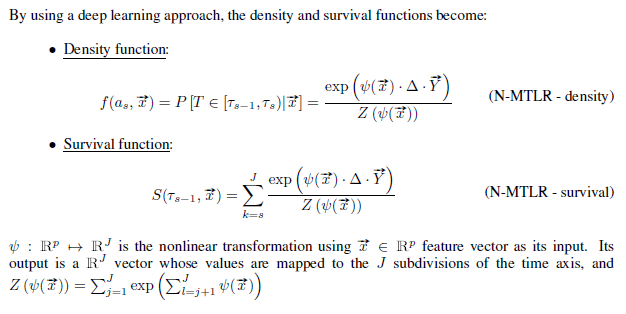





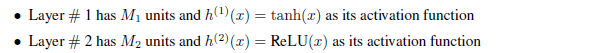


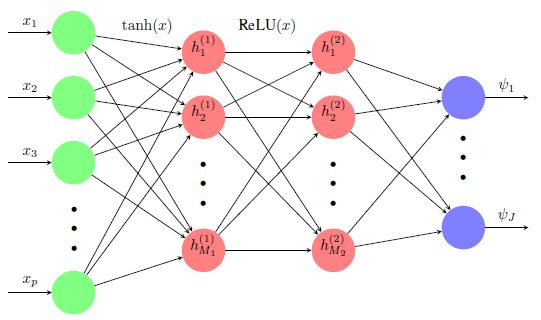

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import GlorotUniform, GlorotNormal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt

class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True, dropout_rate=0.3, l2_lambda=0.01, initializer='glorot_uniform'):
        """
        Initialize the multi-task model.

        Parameters:
        structure (list): List of dictionaries specifying the structure of the neural network.
        bins (int): Number of bins for the time buckets.
        auto_scaler (bool): Whether to automatically scale the features.
        dropout_rate (float): Dropout rate for the layers.
        l2_lambda (float): L2 regularization lambda.
        initializer (str): Initializer for the layers.
        """
        self.structure = structure if structure is not None else [{'activation': 'relu', 'num_units': 128}]
        self.bins = bins
        self.auto_scaler = auto_scaler
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []
        self.val_loss_values = []
        self.initializer = initializer

    def get_initializer(self):
        """
        Get the initializer based on the specified type.

        Returns:
        tf.keras.initializers.Initializer: The initializer.
        """
        if self.initializer == 'glorot_uniform':
            return GlorotUniform()
        elif self.initializer == 'glorot_normal':
            return GlorotNormal()
        else:
            raise ValueError("Initializer not supported. Choose either 'glorot_uniform' or 'glorot_normal'.")

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        """
        Generate the time buckets based on the provided times.

        Parameters:
        T (np.ndarray): Array of times.
        is_min_time_zero (bool): Whether to consider the minimum time as zero.
        extra_pct_time (float): Extra percentage of time to consider for the time buckets.
        """
        max_time = np.max(T)
        min_time = 0. if is_min_time_zero else np.min(T)
        p = extra_pct_time if 0. <= extra_pct_time <= 1. else 0.1

        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.time_buckets = [(self.times[i], self.times[i + 1]) for i in range(len(self.times) - 1)]
        self.num_times = len(self.time_buckets)

    def compute_XY(self, X, T, E, is_min_time_zero=True, extra_pct_time=0.1):
        """
        Compute the X and Y matrices for the censored and uncensored data.

        Parameters:
        X (np.ndarray): Feature matrix.
        T (np.ndarray): Array of times.
        E (np.ndarray): Array of event indicators.
        is_min_time_zero (bool): Whether to consider the minimum time as zero.
        extra_pct_time (float): Extra percentage of time to consider for the time buckets.

        Returns:
        tuple: X_cens, X_uncens, Y_cens, Y_uncens
        """
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]

        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            min_abs_value = [abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets]
            index = np.argmin(min_abs_value)

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[index:] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        X_cens = tf.convert_to_tensor(X_cens, dtype=tf.float32)
        X_uncens = tf.convert_to_tensor(X_uncens, dtype=tf.float32)
        Y_cens = tf.convert_to_tensor(Y_cens, dtype=tf.float32)
        Y_uncens = tf.convert_to_tensor(Y_uncens, dtype=tf.float32)

        return X_cens, X_uncens, Y_cens, Y_uncens

    def loss_function(self, y_true, y_pred, X_uncens, Y_cens, Y_uncens, Triangle, l2_reg, l2_smooth):
        # Assuming y_true and y_pred are used for calculating the loss
        # Note: You may need to adapt the below code depending on your specific requirements

        # Unpack the additional arguments
        model_output, X_cens, X_uncens, Y_cens, Y_uncens, Triangle, l2_reg, l2_smooth = y_true

        # Likelihood Calculations -- Uncensored
        score_uncens = y_pred  # Placeholder for model output for uncensored data
        phi_uncens = tf.exp(tf.matmul(score_uncens, Triangle))
        reduc_phi_uncens = tf.reduce_sum(phi_uncens * Y_uncens, axis=1)

        # Likelihood Calculations -- Censored
        score_cens = y_pred  # Placeholder for model output for censored data
        phi_cens = tf.exp(tf.matmul(score_cens, Triangle))
        reduc_phi_cens = tf.reduce_sum(phi_cens * Y_cens, axis=1)

        # Likelihood Calculations -- Normalization
        z_uncens = tf.exp(tf.matmul(score_uncens, Triangle))
        reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

        z_cens = tf.exp(tf.matmul(score_cens, Triangle))
        reduc_z_cens = tf.reduce_sum(z_cens, axis=1)

        # MTLR cost function
        loss = -(
            tf.reduce_sum(tf.math.log(reduc_phi_uncens)) +
            tf.reduce_sum(tf.math.log(reduc_phi_cens)) -
            tf.reduce_sum(tf.math.log(reduc_z_uncens)) -
            tf.reduce_sum(tf.math.log(reduc_z_cens))
        )

        # Adding the regularized loss
        for w in self.model.trainable_weights:
            loss += l2_reg * tf.reduce_sum(tf.square(w)) / 2.0
            # Ensure smooth variation across consecutive time points (for the last layers)
            loss += l2_smooth * tf.reduce_sum(tf.square(w[:-1] - w[1:])) / 2.0

        return loss

    def norm_diff(self, weights):
        return tf.reduce_sum(tf.square(weights[1:] - weights[:-1]))

    def build_model(self, input_shape):
        """
        Build the neural network model.

        Parameters:
        input_dim (int): Dimension of the input features.

        Returns:
        tf.keras.Model: The compiled model.
        """
        initializer = self.get_initializer()

        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'],
                      kernel_regularizer=l2(self.l2_lambda),
                      kernel_initializer=initializer)(x)
            x = Dropout(self.dropout_rate)(x)
        outputs = Dense(self.num_times + 1, activation='sigmoid', kernel_initializer=initializer)(x)

        self.model = Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=Adam(learning_rate=1e-5, clipnorm=1.0), loss=self.loss_function)
        return self.model

    def fit(self, X, T, E, epochs=1000, batch_size=32, validation_split=0.2, verbose=True):
        """
        Fit the model to the data.

        Parameters:
        X (np.ndarray): Feature matrix.
        T (np.ndarray): Array of times.
        E (np.ndarray): Array of event indicators.
        is_min_time_zero (bool): Whether to consider the minimum time as zero.
        extra_pct_time (float): Extra percentage of time to consider for the time buckets.
        epochs (int): Number of epochs to train.
        batch_size (int): Batch size for training.
        validation_split (float): Fraction of the data to use for validation.
        """
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        self.model = self.build_model(self.num_vars)

        # Train the model
        history = self.model.fit(X_uncens, Y_uncens, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose)
        self.loss_values = history.history['loss']
        self.val_loss_values = history.history['val_loss']

        return self.model

    def plot_loss(self):
        """
        Plot the training and validation loss over epochs.
        """
        plt.plot(self.loss_values, label='Training Loss')
        plt.plot(self.val_loss_values, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def evaluate(self, X_test, T_test, E_test):
        """
        Evaluate the model on the test set.

        Parameters:
        X_test (np.ndarray): Feature matrix for the test set.
        T_test (np.ndarray): Array of times for the test set.
        E_test (np.ndarray): Array of event indicators for the test set.

        Returns:
        float: Concordance index.
        """
        if self.auto_scaler:
            X_test = self.scaler.transform(X_test)

        preds = self.model.predict(X_test)
        risk_scores = np.dot(preds, np.linspace(0, 1, self.num_times + 1))
        return concordance_index_censored(E_test.astype(bool), T_test, risk_scores)[0]


# train 2

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler

class BaseMultiTaskModel:
    def __init__(self, structure, bins, dropout_rate=0.7, l2_lambda=0.001, auto_scaler=True):
        self.structure = structure
        self.bins = bins
        self.num_times = bins - 1
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.auto_scaler = auto_scaler
        self.scaler = StandardScaler() if auto_scaler else None
        self.model = None
        self.loss_values = []
        self.val_loss_values = []

    def get_initializer(self):
        """
        Define the initializer for the model.
        """
        return tf.keras.initializers.GlorotUniform()

    def loss_function(self, Triangle, l2_reg, l2_smooth):
        """
        A closure to define a custom loss function with additional arguments.
        """
        def custom_loss(y_true, y_pred):
            # Extracting censored and uncensored data using y_true
            Y_cens = y_true[:, :self.num_times+1]
            Y_uncens = y_true[:, self.num_times+1:2*(self.num_times+1)]
            X_uncens = y_true[:, 2*(self.num_times+1):]

            # Likelihood Calculations -- Uncensored
            phi_uncens = tf.exp(tf.matmul(y_pred, Triangle))
            reduc_phi_uncens = tf.reduce_sum(phi_uncens * Y_uncens, axis=1)

            # Likelihood Calculations -- Censored
            phi_cens = tf.exp(tf.matmul(y_pred, Triangle))
            reduc_phi_cens = tf.reduce_sum(phi_cens * Y_cens, axis=1)

            # Likelihood Calculations -- Normalization
            z_uncens = tf.exp(tf.matmul(y_pred, Triangle))
            reduc_z_uncens = tf.reduce_sum(z_uncens, axis=1)

            z_cens = tf.exp(tf.matmul(y_pred, Triangle))
            reduc_z_cens = tf.reduce_sum(z_cens, axis=1)

            # MTLR cost function
            loss = -(
                tf.reduce_sum(tf.math.log(reduc_phi_uncens + K.epsilon())) +
                tf.reduce_sum(tf.math.log(reduc_phi_cens + K.epsilon())) -
                tf.reduce_sum(tf.math.log(reduc_z_uncens + K.epsilon())) -
                tf.reduce_sum(tf.math.log(reduc_z_cens + K.epsilon()))
            )

            # Adding the regularized loss
            for w in self.model.trainable_weights:
                loss += l2_reg * tf.reduce_sum(tf.square(w)) / 2.0
                # Ensure smooth variation across consecutive time points (for the last layers)
                loss += l2_smooth * tf.reduce_sum(tf.square(w[:-1] - w[1:])) / 2.0

            return loss

        return custom_loss

    def build_model(self, input_shape, Triangle, l2_reg=0.01, l2_smooth=0.01):
        """
        Build the neural network model.

        Parameters:
        input_shape (int): Dimension of the input features.
        Triangle: matrix for use in the loss function
        l2_reg: L2 regularization factor
        l2_smooth: L2 smoothing factor

        Returns:
        tf.keras.Model: The compiled model.
        """
        initializer = self.get_initializer()

        inputs = Input(shape=(input_shape,))
        x = inputs
        for layer in self.structure:
            x = Dense(units=layer['num_units'], activation=layer['activation'],
                      kernel_regularizer=l2(self.l2_lambda),
                      kernel_initializer=initializer)(x)
            x = Dropout(self.dropout_rate)(x)
        outputs = Dense(self.num_times + 1, activation='sigmoid', kernel_initializer=initializer)(x)

        self.model = Model(inputs=inputs, outputs=outputs)

        # Create the custom loss function with captured arguments
        custom_loss_fn = self.loss_function(
            Triangle=Triangle,
            l2_reg=l2_reg,
            l2_smooth=l2_smooth
        )

        self.model.compile(optimizer=Adam(learning_rate=1e-5, clipnorm=1.0), loss=custom_loss_fn)
        return self.model

    def compute_XY(self, X, T, E, is_min_time_zero=True, extra_pct_time=0.1):
        """
        Compute the design matrices for censored and uncensored data.

        Parameters:
        X (np.ndarray): Feature matrix.
        T (np.ndarray): Array of times.
        E (np.ndarray): Array of event indicators.
        is_min_time_zero (bool): Whether to consider the minimum time as zero.
        extra_pct_time (float): Extra percentage of time to consider for the time buckets.

        Returns:
        Tuple: Design matrices (X_cens, X_uncens, Y_cens, Y_uncens).
        """
        # For demonstration, we'll return dummy values
        # In a real implementation, you would use `X`, `T`, and `E` to create these matrices
        X_cens = X
        X_uncens = X
        Y_cens = np.random.rand(X.shape[0], self.num_times + 1)
        Y_uncens = np.random.rand(X.shape[0], self.num_times + 1)
        return X_cens, X_uncens, Y_cens, Y_uncens

    def fit(self, X, T, E, epochs=1000, batch_size=32, validation_split=0.2, verbose=True):
        """
        Fit the model to the data.

        Parameters:
        X (np.ndarray): Feature matrix.
        T (np.ndarray): Array of times.
        E (np.ndarray): Array of event indicators.
        epochs (int): Number of epochs to train.
        batch_size (int): Batch size for training.
        validation_split (float): Fraction of the data to use for validation.
        verbose (bool): Whether to print detailed logs during training.
        """
        X, T, E = np.array(X), np.array(T), np.array(E)
        self.num_vars = X.shape[1]

        if self.auto_scaler:
            X = self.scaler.fit_transform(X)

        X_cens, X_uncens, Y_cens, Y_uncens = self.compute_XY(X, T, E, True, 0.1)

        # Construct Triangle matrix (adjust size accordingly)
        Triangle = np.eye(self.num_times + 1, self.num_times + 1)

        self.model = self.build_model(self.num_vars, Triangle)

        # Combine X_uncens, Y_cens, Y_uncens into a single y_true
        Y_cens = np.hstack((Y_cens, np.zeros_like(Y_cens), X_uncens))
        Y_uncens = np.hstack((np.zeros_like(Y_uncens), Y_uncens, X_uncens))
        y_true = np.vstack((Y_cens, Y_uncens))

        # Train the model
        history = self.model.fit(X_uncens, y_true, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=verbose)
        self.loss_values = history.history['loss']
        self.val_loss_values = history.history['val_loss']

        return self.model

    def plot_loss(self):
        """
        Plot training and validation loss over epochs.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Training Loss')
        plt.plot(self.val_loss_values, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

    # def evaluate(self, X_test, T_test, E_test):
    #     """
    #     Evaluate the model on test data.

    #     Parameters:
    #     X_test (numpy array or pandas DataFrame): Features of the test set.
    #     T_test (numpy array or pandas Series): Time to event or censoring of the test set.
    #     E_test (numpy array or pandas Series): Event indicator (1 if event occurred, 0 if censored).

    #     Returns:
    #     loss (float): The loss value on the test set.
    #     """
    #     loss = self.model.evaluate([X_test, T_test, E_test], verbose=0)
    #     print(f'Test Loss: {loss}')
    #     return loss

    def predict(self, x):
        """
        Predict the survival probabilities for the given data.

        Parameters:
        X (np.ndarray): Feature matrix.

        Returns:
        np.ndarray: Predicted probabilities.
        """
        if self.auto_scaler:
            x = self.scaler.transform(x)

        x = np.array(x)
        score = self.model.predict(x)

        Triangle1 = np.tri(self.num_times + 1, self.num_times + 1)
        Triangle2 = np.tri(self.num_times + 1, self.num_times + 1)

        phi = np.exp(np.dot(score, Triangle1))
        div = np.repeat(np.sum(phi, 1).reshape(-1, 1), phi.shape[1], axis=1)
        density = phi / div
        Survival = np.dot(density, Triangle2)
        hazard = density[:, :-1] / Survival[:, 1:]



        return hazard, density, Survival


    def predict_risk(self, x, use_log=False):
        """
        Predict the risk for the given data.

        Parameters:
        x (np.ndarray): Feature matrix.
        use_log (bool): Whether to return the log of the risk.

        Returns:
        np.ndarray: Predicted risk.
        """
        _, _, Survival = self.predict(x)
        risk = 1 - Survival[:, -1]
        return np.log(risk) if use_log else risk

    def evaluate(self, X, T, E):
        """
        Evaluate the model using the concordance index.

        Parameters:
        X (np.ndarray): Feature matrix.
        T (np.ndarray): Array of times.
        E (np.ndarray): Array of event indicators.

        Returns:
        float: Concordance index.
        """
        X, T, E = np.array(X), np.array(T), np.array(E)
        if self.auto_scaler:
            X = self.scaler.transform(X)

        _, _, Survival = self.predict(X)

        events = Surv.from_arrays(E == 1, T)
        c_index = concordance_index_censored(E, T, -Survival[:, -1])[0]

        # Calculate the Brier score
        time_grid = np.linspace(0, T.max(), 100)
        brier_scores = []
        for t in time_grid:
            pred_risk = np.mean(Survival[:, :-1] >= t, axis=1)
            brier_score = np.mean((E - pred_risk) ** 2)
            brier_scores.append(brier_score)
        integrated_brier_score = np.trapz(brier_scores, time_grid) / T.max()

        self.plot_brier_score(time_grid, brier_scores, integrated_brier_score)
        self.plot_actual_vs_predicted(T, E, Survival)

        return c_index, integrated_brier_score

    def plot_brier_score(self, time_grid, brier_scores, integrated_brier_score):
        """
        Plot the Brier score curve.

        Parameters:
        time_grid (np.ndarray): Time grid.
        brier_scores (np.ndarray): Brier scores.
        integrated_brier_score (float): Integrated Brier score.
        """
        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, brier_scores, label=f'IBS: {integrated_brier_score:.2f}', color='blue')
        plt.axhline(y=0.25, color='red', linestyle='--', label='0.25 limit')
        plt.title('Prediction Error Curve with Integrated Brier Score')
        plt.xlabel('Time')
        plt.ylabel('Brier Score')
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_actual_vs_predicted(self, T, E, Survival):
        """
        Plot the actual vs. predicted number of events over time.

        Parameters:
        T (np.ndarray): Array of times.
        E (np.ndarray): Array of event indicators.
        Survival (np.ndarray): Survival probabilities.
        """
        time_grid = np.linspace(0, T.max(), 100)
        actual_events = np.array([(T >= t).sum() for t in time_grid])
        predicted_events = np.array([(Survival[:, :-1] >= t).sum() for t in time_grid])

        plt.figure(figsize=(10, 6))
        plt.plot(time_grid, actual_events, label='Actual', color='red')
        plt.plot(time_grid, predicted_events, label='Predicted', color='blue')
        plt.fill_between(time_grid, predicted_events - 1.96 * np.sqrt(predicted_events),
                         predicted_events + 1.96 * np.sqrt(predicted_events), color='blue', alpha=0.2,
                         label='Confidence Intervals')
        plt.title('Actual vs Predicted Number of Events Over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Events')
        plt.legend()
        plt.grid(True)
        plt.show()





# Example usage



In [ ]:
# Assuming you have `train_data` with `X`, `T`, `E` defined

structure = [{'activation': 'tanh', 'num_units': 128},
             {'activation': 'relu', 'num_units': 32},
             {'activation': 'relu', 'num_units': 64}]

# Create the model
model = BaseMultiTaskModel(structure=structure, bins=4)

# Fit the model (replace train_data[X], train_data[T], train_data[E] with actual data)
model.fit(train_data[X], train_data[T], train_data[E], epochs=100, batch_size=32, verbose=True, validation_split=0.2)

Epoch 1/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 603.1740 - val_loss: 600.5169
Epoch 2/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 602.3481 - val_loss: 600.0018
Epoch 3/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 601.5737 - val_loss: 599.4861
Epoch 4/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 601.0291 - val_loss: 598.9685
Epoch 5/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 600.4891 - val_loss: 598.4484
Epoch 6/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 599.5670 - val_loss: 597.9275
Epoch 7/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 599.2556 - val_loss: 597.3978
Epoch 8/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 598.4406 - val_loss: 596.8656
Epoch 9/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 597.7063 - val_loss: 596.3245
Epoch 10/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 597.2703 - val_loss: 595.7802
Epoch 11/100
327/327 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 596.7111 - val_loss: 595.23

<Functional name=functional_13, built=True>

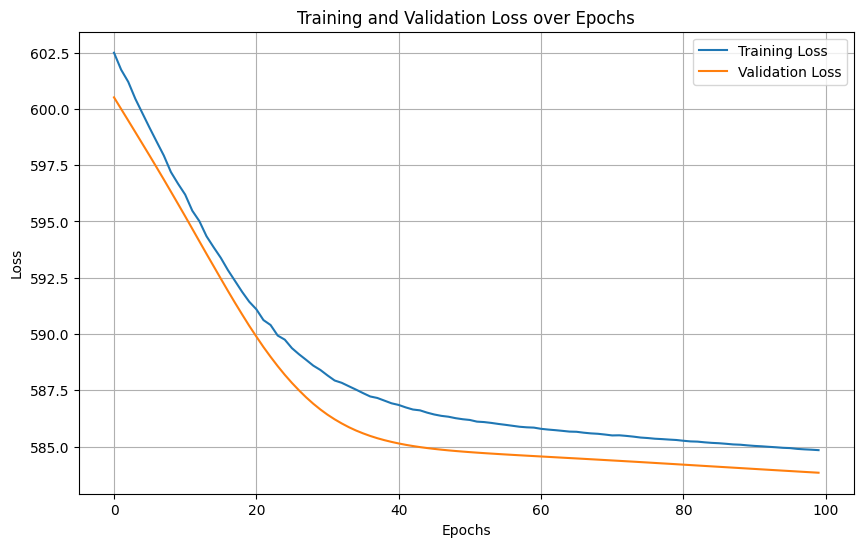

In [ ]:
model.plot_loss()

104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


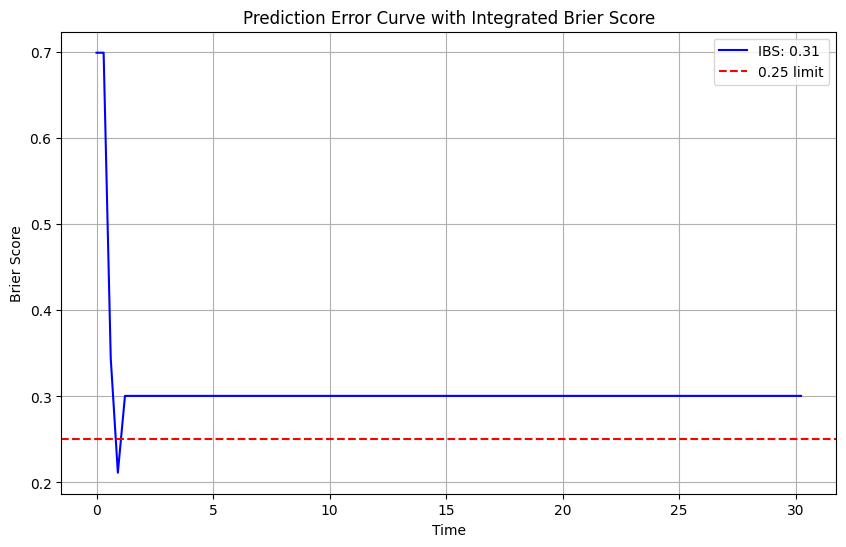

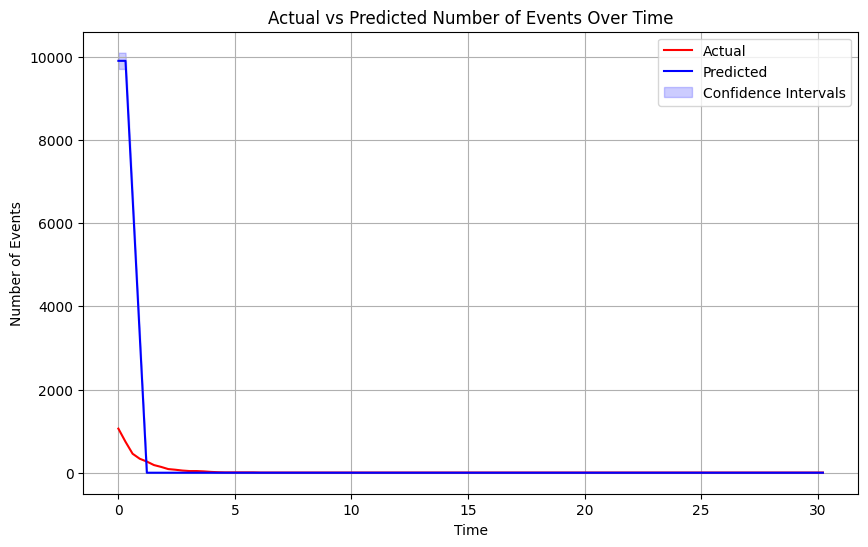

c-index: 0.4447292863002461, Brier score: 0.3061871237628814


In [ ]:
# Evaluate the model
c_index, brier_score = model.evaluate(test_data[X], test_data[T], test_data['SURVIVAL'] == 1) # Access the 'SURVIVAL' column and create a boolean array
print(f"c-index: {c_index}, Brier score: {brier_score}")